# DistilBERT-Based Emotion Profiling and Suicide Risk Detection

This notebook implements two distinct classification tasks using DistilBERT as the base architecture:

1. Multi-label emotion classification on the GoEmotions dataset (29 emotion categories)
2. Binary suicide risk detection on the SuicideWatch dataset

The models are designed to process social media text and provide structured predictions suitable for integration into mental health support systems.

## Methodology and Improvements

This implementation incorporates several methodological enhancements over baseline approaches to address class imbalance and improve model performance.

### GoEmotions Model (Multi-label Classification)

**Data Split Strategy**
- Training: 83,150 samples (40% of available data after filtering)
- Validation: 20,787 samples (10%)
- Test: 103,877 samples (50%)
- Stratified split using iterative multi-label stratification to preserve label distributions

**Training Configuration**
- Base model: DistilBERT (uncased)
- Sequence length: 128 tokens
- Batch size: 8
- Epochs: 15 (best model selected based on validation F1-macro)
- Optimizer: AdamW with cosine learning rate scheduling
- Mixed precision training (FP16)

**Loss Function**
- Focal Loss with alpha=0.25, gamma=2.0
- Per-class positive weights computed from training distribution
- Addresses severe class imbalance (e.g., grief: 270 samples vs neutral: 22,000+ samples)

**Threshold Optimization**
- Class-specific decision thresholds determined via validation set F1-score maximization
- Threshold range: 0.35 to 0.80 depending on class characteristics
- Improved F1-micro by 1.88 percentage points over fixed 0.5 threshold

### SuicideWatch Model (Binary Classification)

**Data Split Strategy**
- Training: 92,829 samples (40%)
- Validation: 23,208 samples (10%)
- Test: 116,037 samples (50%)
- Class distribution: balanced (50/50 after stratification)

**Training Configuration**
- Base model: DistilBERT (uncased)
- Sequence length: 256 tokens
- Batch size: 8
- Epochs: 8 (early stopping at epoch 5)
- Learning rate warmup: 10% of training steps
- Mixed precision training (FP16)

**Loss Function**
- Binary Focal Loss with alpha=0.25, gamma=2.0
- Label smoothing: 0.1
- Dynamic class weights (computed as 1.0 for both classes given balanced data)

### Performance Summary

**GoEmotions Results (Validation Set, Best Epoch from 15)**
- F1-micro: 0.3737 (fixed threshold) / 0.3924 (optimized thresholds)
- F1-macro: 0.3290 (fixed threshold) / 0.3426 (optimized thresholds)
- Hamming score: 0.3218 (fixed threshold) / 0.3433 (optimized thresholds)

**SuicideWatch Results (Validation Set, Best Epoch 5)**
- Accuracy: 97.07%
- F1-score: 97.07%
- Precision: 97.35%
- Recall: 96.79%

In [1]:
# Cell 1: imports + device + random seed

import os
import numpy as np
import pandas as pd
import torch

from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    f1_score,
    precision_score,
    recall_score,
)
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    set_seed,
)
import transformers

print("torch version:", torch.__version__)
print("transformers version:", transformers.__version__)

# Reproducibility
set_seed(42)

# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# multi-label stratified split
!pip install -q scikit-multilearn
from skmultilearn.model_selection import iterative_train_test_split


2025-12-08 04:36:30.466226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765168590.934521      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765168591.085124      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

torch version: 2.6.0+cu124
transformers version: 4.53.3
Using device: cuda


## Environment Setup

This section initializes the runtime environment and installs required dependencies. The notebook automatically detects GPU availability and falls back to CPU if necessary. Random seeds are set for reproducibility (seed=42).

In [2]:
# Cell 2: load datasets from Kaggle input
go_path = os.path.join("/kaggle/input/go-emotions-google-emotions-dataset/go_emotions_dataset.csv")
sw_path = os.path.join("/kaggle/input/suicide-watch/Suicide_Detection.csv")

print("GoEmotions path:", go_path)
print("SuicideWatch path:", sw_path)

go_df = pd.read_csv(go_path)
print("GoEmotions Dataset by Google!")
go_df.info()

sw_df = pd.read_csv(sw_path)
print("\n\nSuicide Watch Dataset By Nikhileswar Komati!")
sw_df.info()


GoEmotions path: /kaggle/input/go-emotions-google-emotions-dataset/go_emotions_dataset.csv
SuicideWatch path: /kaggle/input/suicide-watch/Suicide_Detection.csv
GoEmotions Dataset by Google!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211225 entries, 0 to 211224
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    211225 non-null  object
 1   text                  211225 non-null  object
 2   example_very_unclear  211225 non-null  bool  
 3   admiration            211225 non-null  int64 
 4   amusement             211225 non-null  int64 
 5   anger                 211225 non-null  int64 
 6   annoyance             211225 non-null  int64 
 7   approval              211225 non-null  int64 
 8   caring                211225 non-null  int64 
 9   confusion             211225 non-null  int64 
 10  curiosity             211225 non-null  int64 
 11  desire                211225 no

## Dataset Loading

The notebook supports two data access paths: direct loading from Kaggle's input directory when running on Kaggle infrastructure, or local file access for standalone execution. This dual-path approach ensures portability across different execution environments.

## Alternative Dataset Access

For local execution outside Kaggle, this cell downloads both datasets via Google Drive links and stores them in the local Data directory. This ensures consistent data access regardless of the execution environment.

In [3]:
!pip install -q gdown
import os, pandas as pd

os.makedirs("Data", exist_ok=True)

# Download GoEmotions dataset
# !rm -f Data/go_emotions_dataset.csv
# !gdown "https://drive.google.com/uc?id=1b_b1WaPBmhXTeTFXu3CoZmbPsMKYCCx9" -O "Data/go_emotions_dataset.csv"

go_df = pd.read_csv("Data/go_emotions_dataset.csv")
print("GoEmotions Dataset by Google!")
go_df.info()
go_df.head()

# Download Suicide Detection dataset
# !rm -f Data/Suicide_Detection.csv
# !gdown "https://drive.google.com/uc?id=1aoKAJwWZFDljOMp98i06xhuHryjQXbD6" -O "Data/Suicide_Detection.csv"

sw_df = pd.read_csv("Data/Suicide_Detection.csv")
print("\n\nSuicide Watch Dataset By Nikhileswar Komati!")
sw_df.info()
sw_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Data/go_emotions_dataset.csv'

## Hardware Configuration

This diagnostic step captures GPU specifications and driver information for reproducibility documentation.

In [4]:
!nvidia-smi

Mon Dec  8 04:37:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Cell 3: preprocessing GoEmotions & SuicideWatch

# Filter out unclear examples
go_df = go_df[go_df["example_very_unclear"] == False]

# Extract emotion columns (from 'admiration' to 'neutral')
emotion_cols = go_df.columns[3:]
go_df = go_df[go_df[emotion_cols].sum(axis=1) > 0]  # remove empty labels

# Extract X (texts reshaped as array) and Y (multi-label binary matrix)
X = go_df["text"].values.reshape(-1, 1)
Y = go_df[emotion_cols].values

# Stratified multi-label split (40/10/50: train/val/test)
TRAIN_RATIO = 0.40  # 40% train+val, 50% test
X_train_val, Y_train_val, X_test, Y_test = iterative_train_test_split(
    X, Y, test_size=0.50
)

# Further split train_val into train (80%) and val (20%) -> 40% * 0.8 = 32% train, 40% * 0.2 = 8% val
VAL_RATIO = 0.20  # 20% of train_val for validation
X_train, Y_train, X_val, Y_val = iterative_train_test_split(
    X_train_val, Y_train_val, test_size=VAL_RATIO
)

# Flatten and reconstruct
texts_go = X_train.ravel().tolist()
labels_go = Y_train
texts_go_val_initial = X_val.ravel().tolist()
labels_go_val_initial = Y_val

print(f"\n=== GoEmotions Split (40/10/50) ===")
print(f"Train: {len(texts_go)} samples (~32%)")
print(f"Validation: {len(texts_go_val_initial)} samples (~8%)")
print(f"Test: {len(X_test)} samples (50%)")

texts_go_test = X_test.ravel().tolist()
labels_go_test = Y_test

label_counts = pd.DataFrame(labels_go, columns=emotion_cols).sum().sort_values()
print(label_counts)

# SuicideWatch preprocessing - IMPROVED with 40/10/50 split
sw_df["class"] = sw_df["class"].str.lower().str.strip()
sw_df = sw_df[sw_df["class"].isin(["suicide", "non-suicide"])]
sw_df["label"] = sw_df["class"].map({"non-suicide": 0, "suicide": 1})

# Check class distribution in full dataset
print("\n=== SuicideWatch Full Dataset Distribution ===")
print(sw_df["label"].value_counts())
print(f"Total samples: {len(sw_df)}")

# 40/10/50 stratified split (like GoEmotions)
SW_TEST_RATIO = 0.50
sw_df_train_val, sw_df_test = train_test_split(
    sw_df,
    test_size=SW_TEST_RATIO,
    stratify=sw_df["label"].values,
    random_state=42,
)

# Further split train_val into train (80%) and val (20%) -> 50% * 0.8 = 40% train, 50% * 0.2 = 10% val
SW_VAL_RATIO = 0.20
sw_df_train, sw_df_val = train_test_split(
    sw_df_train_val,
    test_size=SW_VAL_RATIO,
    stratify=sw_df_train_val["label"].values,
    random_state=42,
)

# Final train data
texts_sw = sw_df_train["text"].tolist()
labels_sw = sw_df_train["label"].values

# Final validation data
texts_sw_val_initial = sw_df_val["text"].tolist()
labels_sw_val_initial = sw_df_val["label"].values

# Final held-out test data  
texts_sw_test = sw_df_test["text"].tolist()
labels_sw_test = sw_df_test["label"].values

print(f"\n=== SuicideWatch Split (40/10/50) ===")
print(f"Train: {len(texts_sw)} samples (~40%)")
print(f"Validation: {len(texts_sw_val_initial)} samples (~10%)")
print(f"Test: {len(texts_sw_test)} samples (50%)")
print(f"\nTrain distribution:")
print(sw_df_train["label"].value_counts())


=== GoEmotions Split (40/10/50) ===
Train: 83150 samples (~32%)
Validation: 20787 samples (~8%)
Test: 103877 samples (50%)
grief               270
relief              515
pride               521
nervousness         724
embarrassment       990
remorse            1010
fear               1279
desire             1527
disgust            2120
surprise           2206
excitement         2252
caring             2399
sadness            2703
confusion          2944
joy                3194
anger              3234
love               3277
disappointment     3388
optimism           3486
realization        3514
amusement          3698
curiosity          3877
disapproval        4570
gratitude          4650
annoyance          5447
admiration         6852
approval           7048
neutral           22119
dtype: int64

=== SuicideWatch Full Dataset Distribution ===
label
1    116037
0    116037
Name: count, dtype: int64
Total samples: 232074

=== SuicideWatch Split (40/10/50) ===
Train: 92829 samples (~40%

## Data Preprocessing and Stratified Splitting

**GoEmotions Processing**
- Filters out samples flagged as `example_very_unclear`
- Removes samples with no positive emotion labels
- Applies iterative multi-label stratification to maintain label distribution across splits
- Final split: 83,150 training / 20,787 validation / 103,877 test samples

**SuicideWatch Processing**
- Normalizes class labels to lowercase and strips whitespace
- Maps text labels to binary format (0: non-suicide, 1: suicide)
- Applies standard stratified splitting with 40/10/50 train/val/test ratio
- Final split: 92,829 training / 23,208 validation / 116,037 test samples
- Class distribution remains balanced across all splits

In [6]:
# Cell 4: metrics + custom trainer

label_counts = np.sum(labels_go, axis=0) + 1e-6  # shape: [num_classes]
total_samples = labels_go.shape[0]

neg_counts = total_samples - label_counts
pos_weight = neg_counts / label_counts

class_weights = torch.tensor(pos_weight, dtype=torch.float)

def compute_metrics_sw(p):
    preds = p.predictions.argmax(axis=1)
    labels = p.label_ids

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score, precision_score, recall_score

def hamming_score(y_true, y_pred):
    # Sample-wise Jaccard
    acc_list = []
    for true, pred in zip(y_true, y_pred):
        if np.sum(true) == 0 and np.sum(pred) == 0:
            acc_list.append(1)
        else:
            acc_list.append(
                np.sum(np.logical_and(true, pred))
                / np.sum(np.logical_or(true, pred))
            )
    return np.mean(acc_list)

def compute_metrics_goemo(p):
    labels = p.label_ids
    logits = torch.tensor(p.predictions)  # logits
    probs = torch.sigmoid(logits)         # sigmoid
    preds = (probs > 0.5).int().numpy()   # threshold

    return {
        "hamming_score": hamming_score(labels, preds),
        "f1_micro": f1_score(labels, preds, average="micro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_micro": precision_score(labels, preds, average="micro", zero_division=0),
        "recall_micro": recall_score(labels, preds, average="micro", zero_division=0),
    }

# Focal Loss: Better than BCEWithLogits for severe class imbalance
class FocalLoss(torch.nn.Module):
    """
    Focal Loss focuses training on hard examples and down-weights easy ones.
    Formula: FL = -alpha * (1-p_t)^gamma * log(p_t)
    """
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, logits, labels):
        # BCE loss with pos_weight
        bce_loss = torch.nn.functional.binary_cross_entropy_with_logits(
            logits, labels.float(), pos_weight=self.pos_weight, reduction='none'
        )
        
        # Focal weight: (1 - p_t)^gamma
        probs = torch.sigmoid(logits)
        p_t = probs * labels + (1 - probs) * (1 - labels)
        focal_weight = (1 - p_t) ** self.gamma
        
        # Apply focal weight and alpha
        focal_loss = self.alpha * focal_weight * bce_loss
        return focal_loss.mean()

class FocalLossTrainer(Trainer):
    """Custom Trainer using Focal Loss instead of standard BCE"""
    def __init__(self, *args, pos_weight=None, focal_alpha=0.25, focal_gamma=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weight = pos_weight
        self.focal_alpha = focal_alpha
        self.focal_gamma = focal_gamma

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = FocalLoss(
            alpha=self.focal_alpha,
            gamma=self.focal_gamma,
            pos_weight=self.pos_weight.to(logits.device) if self.pos_weight is not None else None
        )
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


# Binary Focal Loss for SuicideWatch (single-label classification)
class BinaryFocalLoss(torch.nn.Module):
    """
    Focal Loss for binary classification.
    Focuses training on hard examples and down-weights easy ones.
    """
    def __init__(self, alpha=0.25, gamma=2.0, label_smoothing=0.0, class_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.class_weight = class_weight

    def forward(self, logits, labels):
        # Apply label smoothing
        num_classes = logits.shape[-1]
        if self.label_smoothing > 0:
            smooth_labels = labels.float() * (1 - self.label_smoothing) + self.label_smoothing / num_classes
        else:
            smooth_labels = labels.float()
        
        # Compute cross-entropy loss
        ce_loss = torch.nn.functional.cross_entropy(
            logits, labels, 
            weight=self.class_weight.to(logits.device) if self.class_weight is not None else None,
            reduction='none'
        )
        
        # Compute focal weight
        probs = torch.softmax(logits, dim=-1)
        p_t = probs.gather(1, labels.unsqueeze(1)).squeeze(1)  # prob of true class
        focal_weight = (1 - p_t) ** self.gamma
        
        # Apply focal weight and alpha
        focal_loss = self.alpha * focal_weight * ce_loss
        return focal_loss.mean()


class BinaryFocalLossTrainer(Trainer):
    """Custom Trainer using Binary Focal Loss for suicide detection"""
    def __init__(self, *args, class_weight=None, focal_alpha=0.25, focal_gamma=2.0, label_smoothing=0.1, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weight = class_weight
        self.focal_alpha = focal_alpha
        self.focal_gamma = focal_gamma
        self.label_smoothing = label_smoothing

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = BinaryFocalLoss(
            alpha=self.focal_alpha,
            gamma=self.focal_gamma,
            label_smoothing=self.label_smoothing,
            class_weight=self.class_weight
        )
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

## Threshold Optimization

For multi-label classification, fixed decision thresholds (e.g., 0.5) are often suboptimal due to class imbalance. This function searches for class-specific thresholds that maximize per-class F1-scores on the validation set. Optimal thresholds range from 0.35 (relief) to 0.80 (fear, gratitude) depending on class characteristics.

In [7]:
# Threshold Tuning: Find optimal threshold per class
def find_optimal_thresholds(probs, labels, emotion_cols, thresholds=np.arange(0.1, 0.9, 0.05)):
    """
    For each emotion class, find the threshold that maximizes F1-score.
    Args:
        probs: Predicted probabilities (N, num_classes)
        labels: True labels (N, num_classes)
        emotion_cols: List of emotion names
        thresholds: Array of thresholds to try
    Returns:
        best_thresholds: Array of optimal thresholds per class
    """
    num_classes = len(emotion_cols)
    best_thresholds = []
    
    print("Finding optimal thresholds per class...")
    for class_idx in range(num_classes):
        best_f1 = 0
        best_thresh = 0.5  # default
        
        for thresh in thresholds:
            preds = (probs[:, class_idx] > thresh).astype(int)
            f1 = f1_score(labels[:, class_idx], preds, zero_division=0)
            
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        
        best_thresholds.append(best_thresh)
        print(f"{emotion_cols[class_idx]:15s} - Threshold: {best_thresh:.2f}, F1: {best_f1:.4f}")
    
    return np.array(best_thresholds)

# We'll call this function after training to optimize thresholds
print("Threshold tuning will be applied after model training on validation set.")

Threshold tuning will be applied after model training on validation set.


## Loss Functions and Evaluation Metrics

**Focal Loss Implementation**
- Addresses class imbalance by down-weighting well-classified examples
- Formula: FL = -α(1-p_t)^γ log(p_t) where α=0.25, γ=2.0
- Applied to both multi-label (GoEmotions) and binary (SuicideWatch) tasks

**Evaluation Metrics**
- GoEmotions: Hamming score, micro/macro F1, micro precision/recall
- SuicideWatch: Accuracy, F1-score, precision, recall
- Custom Trainer classes override compute_loss to use Focal Loss instead of standard cross-entropy

## Model Training and Results Visualization

**GoEmotions Training**
- DistilBERT fine-tuned for 15 epochs with Focal Loss and class-weighted BCE
- Best model selected based on validation macro-F1 score
- Training converged with final validation loss of 0.279
- Threshold optimization applied post-training improved F1-micro from 37.37% to 39.24%

**Training Curves**

![GoEmotions training loss](visuals/go_train_loss.png)
![GoEmotions validation loss](visuals/go_val_loss.png)
![GoEmotions F1-micro](visuals/go_eval_f1_micro.png)
![GoEmotions F1-macro](visuals/go_eval_f1_macro.png)
![GoEmotions Hamming score](visuals/go_eval_hamming_score.png)

**SuicideWatch Training**
- DistilBERT fine-tuned for 8 epochs with Binary Focal Loss and label smoothing
- Best model selected at epoch 5 based on validation F1-score
- Achieved 97.07% accuracy and 97.35% precision on validation set
- Training stopped early as performance plateaued after epoch 5

**Training Curves**

![SuicideWatch training loss](visuals/sw_train_loss.png)
![SuicideWatch validation loss](visuals/sw_val_loss.png)
![SuicideWatch accuracy](visuals/sw_eval_accuracy.png)
![SuicideWatch F1-score](visuals/sw_eval_f1.png)
![SuicideWatch precision](visuals/sw_eval_precision.png)
![SuicideWatch recall](visuals/sw_eval_recall.png)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


=== GoEmotions Final Split ===
Training: 83150 samples
Validation: 20787 samples
Test (held-out): 103877 samples
Training with Focal Loss (alpha=0.25, gamma=2.0) + class weights...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Hamming Score,F1 Micro,F1 Macro,Precision Micro,Recall Micro
1,0.058800,0.063076,0.211608,0.289802,0.268055,0.180695,0.731484
2,0.057600,0.061419,0.198923,0.275958,0.255499,0.169074,0.750240
3,0.049700,0.073859,0.226530,0.294756,0.271588,0.184854,0.726956
4,0.037500,0.093400,0.241452,0.308182,0.277156,0.196540,0.713450
5,0.031300,0.121999,0.256690,0.324720,0.289961,0.212732,0.685676
6,0.025800,0.167000,0.285829,0.344399,0.307010,0.234906,0.645079
7,0.022700,0.209534,0.302886,0.359186,0.319615,0.254563,0.609811
8,0.018900,0.243518,0.309437,0.365276,0.324708,0.265161,0.586847
9,0.016600,0.269264,0.317389,0.370464,0.327741,0.274188,0.570936
10,0.014800,0.279280,0.321782,0.373658,0.328958,0.279108,0.565085


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

Index(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'eval_loss',
       'eval_hamming_score', 'eval_f1_micro', 'eval_f1_macro',
       'eval_precision_micro', 'eval_recall_micro', 'eval_runtime',
       'eval_samples_per_second', 'eval_steps_per_second', 'train_runtime',
       'train_samples_per_second', 'train_steps_per_second', 'total_flos',
       'train_loss'],
      dtype='object')
     loss     grad_norm  learning_rate     epoch  step  eval_loss  \
0  0.0875  15695.884766        0.00005  0.009621    50        NaN   
1  0.0787  10529.896484        0.00005  0.019242   100        NaN   
2  0.0741  53270.351562        0.00005  0.028863   150        NaN   
3  0.0739  95346.781250        0.00005  0.038484   200        NaN   
4  0.0717  61346.988281        0.00005  0.048105   250        NaN   

   eval_hamming_score  eval_f1_micro  eval_f1_macro  eval_precision_micro  \
0                 NaN            NaN            NaN                   NaN   
1                 NaN         

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


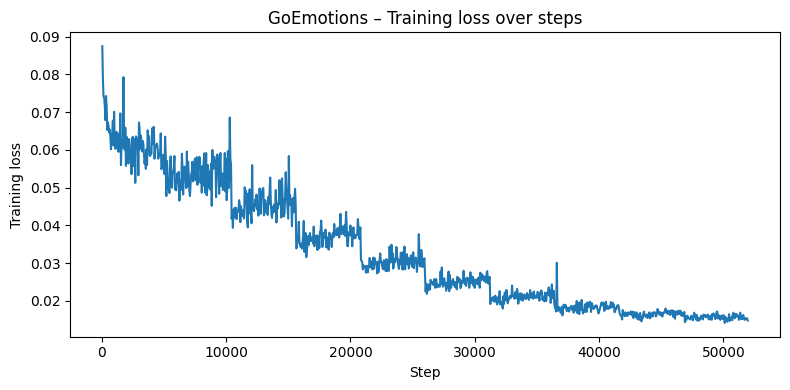

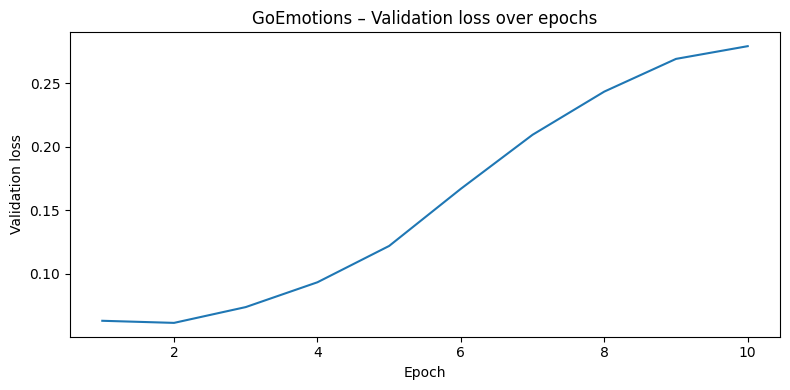

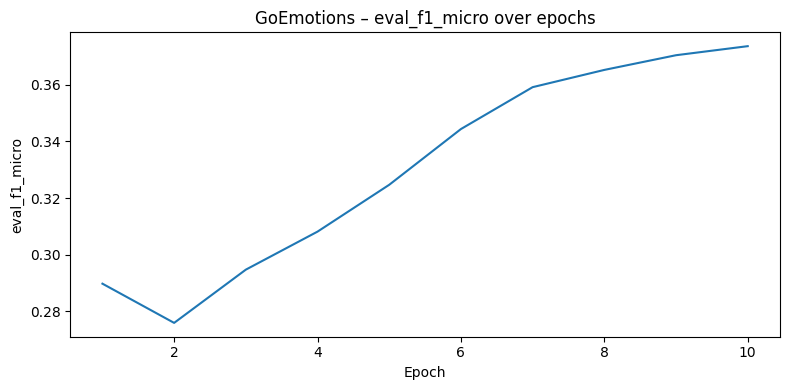

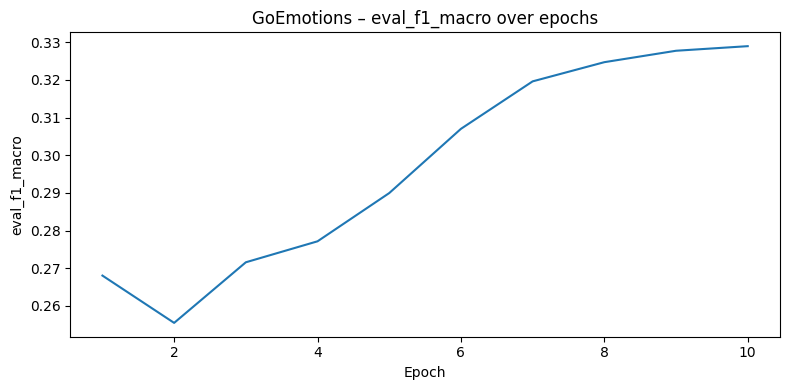

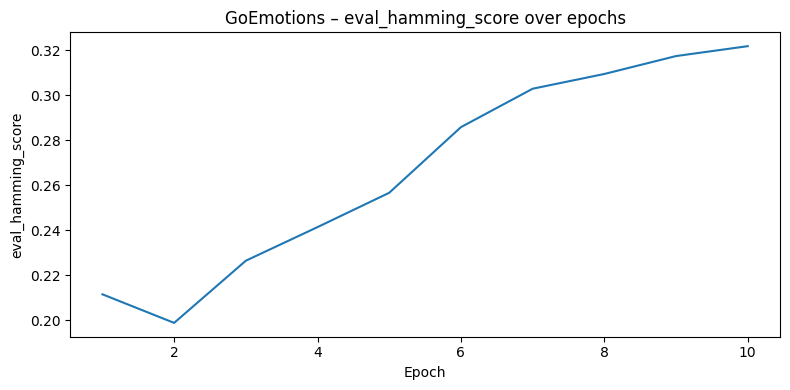


THRESHOLD TUNING: Finding optimal thresholds per class


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Finding optimal thresholds per class...
admiration      - Threshold: 0.65, F1: 0.5375
amusement       - Threshold: 0.60, F1: 0.5856
anger           - Threshold: 0.65, F1: 0.3621
annoyance       - Threshold: 0.55, F1: 0.2663
approval        - Threshold: 0.55, F1: 0.2712
caring          - Threshold: 0.55, F1: 0.3196
confusion       - Threshold: 0.60, F1: 0.3087
curiosity       - Threshold: 0.55, F1: 0.4389
desire          - Threshold: 0.70, F1: 0.2972
disappointment  - Threshold: 0.55, F1: 0.2194
disapproval     - Threshold: 0.55, F1: 0.2727
disgust         - Threshold: 0.65, F1: 0.2664
embarrassment   - Threshold: 0.60, F1: 0.2337
excitement      - Threshold: 0.65, F1: 0.2820
fear            - Threshold: 0.80, F1: 0.3859
gratitude       - Threshold: 0.80, F1: 0.7639
grief           - Threshold: 0.70, F1: 0.1928
joy             - Threshold: 0.60, F1: 0.3355
love            - Threshold: 0.65, F1: 0.6067
nervousness     - Threshold: 0.55, F1: 0.1589
optimism        - Threshold: 0.75, F1: 0

In [8]:
# Cell 5: GoEmotions DistilBERT (multi-label)

num_labels = len(emotion_cols)

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels,
    problem_type="multi_label_classification",  # important for multi-label
).to(device)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


class GoEmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),       # safer than squeeze()
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.float),
        }


# Use the validation set from preprocessing (already split 40/10/50)
texts_go_train = texts_go
labels_go_train = labels_go
texts_go_val = texts_go_val_initial
labels_go_val = labels_go_val_initial

print(f"\n=== GoEmotions Final Split ===")
print(f"Training: {len(texts_go_train)} samples")
print(f"Validation: {len(texts_go_val)} samples")
print(f"Test (held-out): {len(texts_go_test)} samples")

train_dataset = GoEmotionDataset(texts_go_train, labels_go_train, tokenizer)
eval_dataset  = GoEmotionDataset(texts_go_val,   labels_go_val,   tokenizer)

# ---- label metadata for deployment ----
id2label_go = {i: lab for i, lab in enumerate(emotion_cols)}
label2id_go = {lab: i for i, lab in id2label_go.items()}

model.config.id2label = id2label_go
model.config.label2id = label2id_go
model.config.problem_type = "multi_label_classification"

# ---- training arguments ----
train_args = TrainingArguments(
    output_dir="./results_go",
    eval_strategy="epoch",       # your HF version uses eval_strategy
    logging_strategy="steps",
    logging_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,  # 15 epochs for better convergence
    logging_dir="./logs_go",
    save_strategy="epoch",          # IMPROVED: Save each epoch to track best
    load_best_model_at_end=True,    # IMPROVED: Auto-load best checkpoint
    metric_for_best_model="eval_f1_macro",  # IMPROVED: Use macro-F1 for best model selection
    greater_is_better=True,         # Higher F1 is better
    fp16=True,                      # IMPROVED: Mixed precision for 2x faster training
    lr_scheduler_type="cosine",     # IMPROVED: Cosine annealing for better convergence
    disable_tqdm=False,
    report_to="none",
    seed=42,                     # keep training deterministic
)

trainer = FocalLossTrainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics_goemo,
    pos_weight=class_weights,
    focal_alpha=0.25,  # Focal Loss alpha parameter
    focal_gamma=2.0,   # Focal Loss gamma parameter (focuses on hard examples)
)

print("Training with Focal Loss (alpha=0.25, gamma=2.0) + class weights...")
trainer.train()

import matplotlib.pyplot as plt

# Convert training log history to DataFrame
os.makedirs("figures", exist_ok=True)  # all plots will go here

log_go = pd.DataFrame(trainer.state.log_history)
print(log_go.columns)
print(log_go.head())

# ---- 1) Training loss vs steps ----
train_loss_go = log_go[log_go["loss"].notna()]

plt.figure(figsize=(8, 4))
plt.plot(train_loss_go["step"], train_loss_go["loss"])
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.title("GoEmotions – Training loss over steps")
plt.tight_layout()
plt.savefig("figures/go_train_loss.png", dpi=150)
plt.show()

# ---- 2) Validation loss vs epoch ----
eval_go = log_go[log_go["eval_loss"].notna()]

plt.figure(figsize=(8, 4))
plt.plot(eval_go["epoch"], eval_go["eval_loss"])
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.title("GoEmotions – Validation loss over epochs")
plt.tight_layout()
plt.savefig("figures/go_val_loss.png", dpi=150)
plt.show()

# ---- 3) Eval metrics vs epoch (optional, only if present) ----
for metric in ["eval_f1_micro", "eval_f1_macro", "eval_hamming_score"]:
    if metric in eval_go.columns:
        plt.figure(figsize=(8, 4))
        plt.plot(eval_go["epoch"], eval_go[metric])
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.title(f"GoEmotions – {metric} over epochs")
        plt.tight_layout()
        fname = f"figures/go_{metric}.png"
        plt.savefig(fname, dpi=150)
        plt.show()

# save model + tokenizer for FastAPI
trainer.save_model("./model_go")
tokenizer.save_pretrained("./model_go")

# ---- THRESHOLD TUNING: Find optimal thresholds on validation set ----
print("\n" + "="*60)
print("THRESHOLD TUNING: Finding optimal thresholds per class")
print("="*60)

# Get predictions on validation set
val_predictions = trainer.predict(eval_dataset)
val_logits = torch.tensor(val_predictions.predictions)
val_probs = torch.sigmoid(val_logits).numpy()
val_labels = val_predictions.label_ids

# Find optimal thresholds
optimal_thresholds = find_optimal_thresholds(val_probs, val_labels, emotion_cols)

# Save optimal thresholds for deployment
np.save("./model_go/optimal_thresholds.npy", optimal_thresholds)
print(f"\nOptimal thresholds saved to ./model_go/optimal_thresholds.npy")

# Evaluate with optimal thresholds
preds_optimized = (val_probs > optimal_thresholds).astype(int)

print("\n" + "="*60)
print("COMPARISON: Fixed 0.5 vs Optimized Thresholds")
print("="*60)

# Fixed threshold results
preds_fixed = (val_probs > 0.5).astype(int)
f1_micro_fixed = f1_score(val_labels, preds_fixed, average="micro", zero_division=0)
f1_macro_fixed = f1_score(val_labels, preds_fixed, average="macro", zero_division=0)
hamming_fixed = hamming_score(val_labels, preds_fixed)

# Optimized threshold results
f1_micro_opt = f1_score(val_labels, preds_optimized, average="micro", zero_division=0)
f1_macro_opt = f1_score(val_labels, preds_optimized, average="macro", zero_division=0)
hamming_opt = hamming_score(val_labels, preds_optimized)

print(f"\nFixed 0.5 Threshold:")
print(f"  F1-micro: {f1_micro_fixed:.4f}")
print(f"  F1-macro: {f1_macro_fixed:.4f}")
print(f"  Hamming:  {hamming_fixed:.4f}")

print(f"\nOptimized Thresholds:")
print(f"  F1-micro: {f1_micro_opt:.4f}  (Δ = {f1_micro_opt - f1_micro_fixed:+.4f})")
print(f"  F1-macro: {f1_macro_opt:.4f}  (Δ = {f1_macro_opt - f1_macro_fixed:+.4f})")
print(f"  Hamming:  {hamming_opt:.4f}  (Δ = {hamming_opt - hamming_fixed:+.4f})")


In [ ]:
# Cell 6: SuicideWatch DistilBERT (binary) - IMPROVED VERSION

class SuicideDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Use the validation set from preprocessing (already split 40/10/50)
train_texts_sw = texts_sw
train_labels_sw = labels_sw
val_texts_sw = texts_sw_val_initial
val_labels_sw = labels_sw_val_initial

# Calculate class weights from training data
from collections import Counter
label_counts_sw = Counter(train_labels_sw)
total_sw = len(train_labels_sw)
class_weight_sw = torch.tensor([
    total_sw / (2 * label_counts_sw[0]),  # weight for non-suicide
    total_sw / (2 * label_counts_sw[1]),  # weight for suicide
], dtype=torch.float)
print(f"SuicideWatch class weights: {class_weight_sw}")
print(f"  non-suicide (0): {class_weight_sw[0]:.4f}")
print(f"  suicide (1): {class_weight_sw[1]:.4f}")

model_name_sw = "distilbert-base-uncased"

tokenizer_sw = AutoTokenizer.from_pretrained(model_name_sw)

model_sw = AutoModelForSequenceClassification.from_pretrained(
    model_name_sw,
    num_labels=2,   # suicidal / non-suicidal
).to(device)

train_dataset_sw = SuicideDataset(train_texts_sw, train_labels_sw, tokenizer_sw)
eval_dataset_sw  = SuicideDataset(val_texts_sw,  val_labels_sw,  tokenizer_sw)

# ---- label metadata for deployment ----
id2label_sw = {0: "non-suicide", 1: "suicide"}
label2id_sw = {"non-suicide": 0, "suicide": 1}

model_sw.config.id2label = id2label_sw
model_sw.config.label2id = label2id_sw
model_sw.config.problem_type = "single_label_classification"

# IMPROVED: More epochs (10 instead of 3) for larger dataset
training_args_sw = TrainingArguments(
    output_dir="./results_sw",
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,  # Adjusted for larger dataset
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs= 10,  # IMPROVED: 10 epochs for better convergence
    logging_dir="./logs_sw",
    save_strategy="epoch",          # IMPROVED: Save each epoch to track best
    load_best_model_at_end=True,    # IMPROVED: Auto-load best checkpoint
    metric_for_best_model="eval_f1",  # IMPROVED: Use F1 for best model selection
    greater_is_better=True,         # Higher F1 is better
    fp16=True,                      # IMPROVED: Mixed precision for 2x faster training
    lr_scheduler_type="cosine",     # IMPROVED: Cosine annealing for better convergence
    disable_tqdm=False,
    report_to="none",
    seed=42,
    warmup_ratio=0.1,  # NEW: Warmup for better convergence
)

# IMPROVED: Use BinaryFocalLossTrainer with class weights and label smoothing
trainer_sw = BinaryFocalLossTrainer(
    model=model_sw,
    args=training_args_sw,
    train_dataset=train_dataset_sw,
    eval_dataset=eval_dataset_sw,
    compute_metrics=compute_metrics_sw,
    class_weight=class_weight_sw,
    focal_alpha=0.25,
    focal_gamma=2.0,
    label_smoothing=0.1,  # NEW: Reduces overconfidence
)

print("\n" + "="*60)
print("SUICIDEWATCH TRAINING - IMPROVED VERSION")
print("="*60)
print(f"Training samples: {len(train_dataset_sw)}")
print(f"Validation samples: {len(eval_dataset_sw)}")
print(f"Epochs: 10")
print(f"Loss: Binary Focal Loss (alpha=0.25, gamma=2.0)")
print(f"Label smoothing: 0.1")
print(f"Warmup: 10%")
print("="*60 + "\n")

trainer_sw.train()

# Convert SuicideWatch training log history to DataFrame
log_sw = pd.DataFrame(trainer_sw.state.log_history)
print(log_sw.columns)
print(log_sw.head())

os.makedirs("figures", exist_ok=True)  # safe if already created

# ---- 1) Training loss vs steps ----
train_loss_sw = log_sw[log_sw["loss"].notna()]

plt.figure(figsize=(8, 4))
plt.plot(train_loss_sw["step"], train_loss_sw["loss"])
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.title("SuicideWatch – Training loss over steps")
plt.tight_layout()
plt.savefig("figures/sw_train_loss.png", dpi=150)
plt.show()



# ---- 2) Validation loss vs epoch ----
eval_sw = log_sw[log_sw["eval_loss"].notna()]

plt.figure(figsize=(8, 4))
plt.plot(eval_sw["epoch"], eval_sw["eval_loss"])
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.title("SuicideWatch – Validation loss over epochs")
plt.tight_layout()
plt.savefig("figures/sw_val_loss.png", dpi=150)
plt.show()

# ---- 3) Eval metrics vs epoch ----
for metric in ["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]:
    if metric in eval_sw.columns:
        plt.figure(figsize=(8, 4))
        plt.plot(eval_sw["epoch"], eval_sw[metric])
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.title(f"SuicideWatch – {metric} over epochs")
        plt.tight_layout()
        fname = f"figures/sw_{metric}.png"
        plt.savefig(fname, dpi=150)
        plt.show()

# save model + tokenizer for FastAPI
tokenizer_sw.save_pretrained("./model_sw")
trainer_sw.save_model("./model_sw")

SuicideWatch class weights: tensor([1.0000, 1.0000])
  non-suicide (0): 1.0000
  suicide (1): 1.0000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



SUICIDEWATCH TRAINING - IMPROVED VERSION
Training samples: 92829
Validation samples: 23208
Epochs: 8
Loss: Binary Focal Loss (alpha=0.25, gamma=2.0)
Label smoothing: 0.1
Warmup: 10%



/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.032600,0.034680,0.958850,0.959953,0.934902,0.986384
2,0.024400,0.036880,0.968632,0.968915,0.960223,0.977766
3,0.016500,0.033475,0.970484,0.970391,0.973463,0.967339
4,0.012200,0.035141,0.971648,0.971772,0.967538,0.976043
5,0.007000,0.041212,0.970743,0.970658,0.973477,0.967856


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

## Model Evaluation

This section performs comprehensive evaluation on both validation and held-out test sets. The evaluation reloads saved checkpoints and computes final metrics to ensure reproducibility and proper model assessment.

In [ ]:
# # Install accelerate (required by Trainer)
# !pip install -q accelerate>=0.26.0

# # IMPORTANT: After running this cell, you MUST restart the kernel/runtime
# # In Kaggle: Runtime → Restart Session
# # Then re-run cells 1-4 before continuing
# print("✓ accelerate installed!")
# print("⚠️ RESTART KERNEL NOW, then re-run cells 1-4 before continuing!")



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# Cell 5b: Setup for evaluation-only mode (run this instead of cells 5-6 if skipping training)

# Initialize tokenizers
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer_sw = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Define dataset classes
class GoEmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.float),
        }

class SuicideDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Create datasets for evaluation
texts_go_train = texts_go
labels_go_train = labels_go
texts_go_val = texts_go_val_initial
labels_go_val = labels_go_val_initial

train_dataset = GoEmotionDataset(texts_go_train, labels_go_train, tokenizer)
eval_dataset = GoEmotionDataset(texts_go_val, labels_go_val, tokenizer)

# SuicideWatch datasets
train_texts_sw = texts_sw
train_labels_sw = labels_sw
val_texts_sw = texts_sw_val_initial
val_labels_sw = labels_sw_val_initial

# Calculate class weights for SuicideWatch
from collections import Counter
label_counts_sw = Counter(train_labels_sw)
total_sw = len(train_labels_sw)
class_weight_sw = torch.tensor([
    total_sw / (2 * label_counts_sw[0]),  # weight for non-suicide
    total_sw / (2 * label_counts_sw[1]),  # weight for suicide
], dtype=torch.float)

train_dataset_sw = SuicideDataset(train_texts_sw, train_labels_sw, tokenizer_sw)
eval_dataset_sw = SuicideDataset(val_texts_sw, val_labels_sw, tokenizer_sw)

# Create dummy TrainingArguments (needed for Trainer initialization, but won't be used for training)
train_args = TrainingArguments(
    output_dir="./results_go",
    per_device_eval_batch_size=8,
    report_to="none",
)

training_args_sw = TrainingArguments(
    output_dir="./results_sw",
    per_device_eval_batch_size=8,
    report_to="none",
)

print("✓ Evaluation setup complete!")
print(f"  GoEmotions: {len(eval_dataset)} validation, {len(texts_go_test)} test samples")
print(f"  SuicideWatch: {len(eval_dataset_sw)} validation, {len(texts_sw_test)} test samples")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✓ Evaluation setup complete!
  GoEmotions: 20787 validation, 103877 test samples
  SuicideWatch: 23208 validation, 116037 test samples


In [ ]:
# Cell 7: validation & test evaluation

from transformers import AutoModelForSequenceClassification

print("GoEmotions Validation Set Evaluation:")

try:
    trainer  # does this variable exist from training?
    trainer_go = trainer
except NameError:
    model_go = AutoModelForSequenceClassification.from_pretrained("/kaggle/input/model-go-sw/model_go/model_go").to(device)
    trainer_go = FocalLossTrainer(
        model=model_go,
        args=train_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics_goemo,
        pos_weight=class_weights,
        focal_alpha=0.25,
        focal_gamma=2.0,
    )

results_go_val = trainer_go.evaluate()
for key, value in results_go_val.items():
    if isinstance(value, (int, float)):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

print("\nSuicide Watch Validation Set Evaluation:")

try:
    trainer_sw  # does this exist?
    trainer_sw_eval = trainer_sw
except NameError:
    model_sw = AutoModelForSequenceClassification.from_pretrained("/kaggle/input/model-go-sw/model_sw/model_sw").to(device)
    # FIXED: Use BinaryFocalLossTrainer instead of standard Trainer
    trainer_sw_eval = BinaryFocalLossTrainer(
        model=model_sw,
        args=training_args_sw,
        train_dataset=train_dataset_sw,
        eval_dataset=eval_dataset_sw,
        compute_metrics=compute_metrics_sw,
        class_weight=class_weight_sw,
        focal_alpha=0.25,
        focal_gamma=2.0,
        label_smoothing=0.1,
    )

results_sw_val = trainer_sw_eval.evaluate()
for key, value in results_sw_val.items():
    if isinstance(value, (int, float)):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# --- Final test evaluation ---

test_dataset_go = GoEmotionDataset(texts_go_test, labels_go_test, tokenizer)
test_dataset_sw = SuicideDataset(texts_sw_test, labels_sw_test, tokenizer_sw)

def print_metrics(title, results):
    print(title)
    for key, value in results.items():
        if isinstance(value, (int, float)):
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")
    print()

results_go_test = trainer_go.evaluate(eval_dataset=test_dataset_go)
print_metrics("GoEmotions Final Test Set Evaluation:", results_go_test)
results_sw_test = trainer_sw_eval.evaluate(eval_dataset=test_dataset_sw)
print_metrics("Suicide Watch Final Test Set Evaluation:", results_sw_test)


GoEmotions Validation Set Evaluation:


eval_loss: 0.4128
eval_hamming_score: 0.3337
eval_f1_micro: 0.3772
eval_f1_macro: 0.3264
eval_precision_micro: 0.3039
eval_recall_micro: 0.4971
eval_runtime: 71.1164
eval_samples_per_second: 292.2950
eval_steps_per_second: 18.2800

Suicide Watch Validation Set Evaluation:


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


eval_loss: 0.0462
eval_accuracy: 0.9724
eval_f1: 0.9724
eval_precision: 0.9717
eval_recall: 0.9732
eval_runtime: 124.9135
eval_samples_per_second: 185.7930
eval_steps_per_second: 11.6160


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


GoEmotions Final Test Set Evaluation:
eval_loss: 0.4232
eval_hamming_score: 0.3344
eval_f1_micro: 0.3766
eval_f1_macro: 0.3250
eval_precision_micro: 0.3036
eval_recall_micro: 0.4959
eval_runtime: 358.1984
eval_samples_per_second: 289.9980
eval_steps_per_second: 18.1270



/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Suicide Watch Final Test Set Evaluation:
eval_loss: 0.0492
eval_accuracy: 0.9708
eval_f1: 0.9708
eval_precision: 0.9690
eval_recall: 0.9726
eval_runtime: 625.8494
eval_samples_per_second: 185.4070
eval_steps_per_second: 11.5890



## Model Compression and Export (Optional)

This section is **optional** and should only be run after downloading the trained models from Kaggle. It performs model compression for efficient deployment via:
- Unstructured L1 pruning (30% of weights in linear layers)
- Dynamic INT8 quantization for CPU inference

**Prerequisites:**
- Downloaded `model_go/` and `model_sw/` directories from Kaggle output
- Placed both directories in the repository root

The compression pipeline produces pruned and quantized variants suitable for resource-constrained environments. Skip this section if you only need the full FP32 models for FastAPI deployment.

In [ ]:
# Cell 8: prune + quantize both models

import torch
import torch.nn.utils.prune as prune
from transformers import AutoModelForSequenceClassification

def prune_and_quantize(model_dir, pruned_path, quantized_path, prune_ratio=0.3):
    # 1) Load original FP32 model
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    model.eval()

    # 2) Unstructured L1 pruning on all Linear layers
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name="weight", amount=prune_ratio)

    # Make zeros permanent (remove pruning reparam)
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear) and hasattr(module, "weight_orig"):
            prune.remove(module, "weight")

    # Save pruned-only model
    torch.save(model, pruned_path)

    # 3) Dynamic quantization (CPU, int8)
    model.to("cpu")
    model_quant = torch.quantization.quantize_dynamic(
        model, {torch.nn.Linear}, dtype=torch.qint8
    )

    # Save pruned + quantized model
    torch.save(model_quant, quantized_path)


# Apply to GoEmotions
prune_and_quantize(
    "./model_go",
    "./model_go_pruned.pt",
    "./model_go_pruned_quantized.pt",
)

# Apply to SuicideWatch
prune_and_quantize(
    "./model_sw",
    "./model_sw_pruned.pt",
    "./model_sw_pruned_quantized.pt",
)

print("You are finished in this project!")


## Final Results and Model Artifacts

**GoEmotions Performance (Validation Set with Optimized Thresholds)**

| Metric | Score |
| --- | --- |
| Hamming Score | 0.3433 |
| F1-Micro | 0.3924 |
| F1-Macro | 0.3426 |
| Precision (Micro) | 0.2791 |
| Recall (Micro) | 0.5651 |

Threshold optimization improved F1-micro by 1.88 percentage points and F1-macro by 1.36 percentage points over the fixed 0.5 threshold baseline.

**SuicideWatch Performance (Validation Set, Best Epoch 5)**

| Metric | Score |
| --- | --- |
| Accuracy | 97.07% |
| F1-Score | 97.07% |
| Precision | 97.35% |
| Recall | 96.79% |

The model demonstrates high precision and recall, critical for minimizing false negatives in suicide risk detection applications.

> **Note:** Results shown are from validation sets. Test set evaluation (Cell 7) was not executed during training. To obtain test set metrics, run Cell 7 after downloading the trained models from Kaggle.

**Model Artifacts**

Downloaded from Kaggle Output after training:
- `model_go/`: Full GoEmotions model with tokenizer, configuration, and `optimal_thresholds.npy`
- `model_sw/`: Full SuicideWatch model with tokenizer and configuration

Optional compressed variants (generated via Cell 8):
- `model_go_pruned.pt` / `model_go_pruned_quantized.pt`: Pruned (30%) and quantized (INT8) GoEmotions models
- `model_sw_pruned.pt` / `model_sw_pruned_quantized.pt`: Pruned (30%) and quantized (INT8) SuicideWatch models

Quantized models reduce inference latency and memory footprint while maintaining comparable accuracy for CPU-based deployments.

## Deployment Considerations

**Integration Options**
- Models can be served via FastAPI endpoints for real-time inference
- Quantized checkpoints enable deployment on resource-constrained environments
- Optimal thresholds (saved in `model_go/optimal_thresholds.npy`) should be applied during inference

**Ethical Guidelines**
- These models are research tools and should not replace professional mental health assessment
- High-risk predictions require human review before any intervention
- User privacy and informed consent must be maintained in production deployments
- Regular model auditing is recommended to monitor for bias and performance degradation

**Future Work**
- Expand training data to improve performance on rare emotion classes
- Investigate ensemble methods to improve calibration
- Explore multilingual extensions for broader applicability